# My Information:

- **Name:** Anthony DiSpirito
- **NetID:** ad424
- **Number of Group Members:** 1
- **Class:** BME590 - Health Data Science
- **Assignment:** Final Project
- **Date:** 05/01/20
- **Github:** https://github.com/axd465/final-proj-axd465

# Overview and Background

* Patient mortality is the worst outcome imaginable. This is especially true when the death occurs within 24-48 hours after discharge, as keeping the patient in the hsopital longer may save their life. So by using the MIMICIII dataset, I wanted to create a predictive model that from a very simple patient feature set, accurately predict patient mortality within 24-48 hours. In addition, I thought it would be interesting to try to build a compound model that could predict both short term mortality (24hr and 48hr), but also long term mortality at 1yr. My approach was to develop a simple feature set, clean the data, and use a simple deep learning model to predict 24hr, 48hr, and 1yr mortality accurately.

# Import Statements

In [213]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
import psycopg2
import getpass
from tensorflow.keras.layers import Input,Dense,Activation,Dropout,Concatenate,Add
from tensorflow.keras.models import Model
%matplotlib inline

# Data

## Create a database connection

In [2]:
user = 'postgres'
host = 'localhost'
dbname = 'mimic'
schema = 'mimiciii'

## Connect to the database

In [5]:
con = psycopg2.connect(dbname=dbname, user=user, host=host, 
                       password=getpass.getpass(prompt='Password:'.format(user)))
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema))

Password: ········


### Testing Connection

In [6]:
# Get length of stay from the icustays table
query = \
"""
SELECT i.subject_id, i.hadm_id, i.los
FROM icustays i;
"""

data = pd.read_sql_query(query,con)
data

,subject_id,hadm_id,los
0,268,110404,3.2490
1,269,106296,3.2788
2,270,188028,2.8939
3,271,173727,2.0600
4,272,164716,1.6202
...,...,...,...
61527,94944,143774,2.1894
61528,94950,123750,2.4942
61529,94953,196881,0.9259
61530,94954,118475,2.3346


## Initial Exploration

### Get List of CSV Files

In [7]:
ROOT = os.getcwd()
DATA_ROOT = 'Z:\PersonalDatabase\mimic-iii-clinical-database-1.4\data'
os.chdir(DATA_ROOT)
print(f'\nThe Currect Working Directory is: {os.getcwd()}\n')
print('LIST OF CSV FILES:\n_________________')
for file in os.listdir(DATA_ROOT):
    print(file)


The Currect Working Directory is: Z:\PersonalDatabase\mimic-iii-clinical-database-1.4\data

LIST OF CSV FILES:
_________________
ADMISSIONS.csv
CALLOUT.csv
CAREGIVERS.csv
CHARTEVENTS.csv
CPTEVENTS.csv
DATETIMEEVENTS.csv
DIAGNOSES_ICD.csv
DRGCODES.csv
D_CPT.csv
D_ICD_DIAGNOSES.csv
D_ICD_PROCEDURES.csv
D_ITEMS.csv
D_LABITEMS.csv
ICUSTAYS.csv
INPUTEVENTS_CV.csv
INPUTEVENTS_MV.csv
LABEVENTS.csv
MICROBIOLOGYEVENTS.csv
NOTEEVENTS.csv
OUTPUTEVENTS.csv
PATIENTS.csv
PRESCRIPTIONS.csv
PROCEDUREEVENTS_MV.csv
PROCEDURES_ICD.csv
SERVICES.csv
TRANSFERS.csv


### Let's See What These Tables Look Like

In [9]:
for file in os.listdir(DATA_ROOT):
    item = os.path.splitext(file)[0]
    print(f'\n{item.upper()} TABLE: \n')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(pd.read_sql(f"SELECT * FROM {item} LIMIT 2", con))
    line = '------'
    print(f'\n{30*line}\n')


ADMISSIONS TABLE: 



,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,None,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


CALLOUT TABLE: 



,row_id,subject_id,hadm_id,submit_wardid,submit_careunit,curr_wardid,curr_careunit,callout_wardid,callout_service,request_tele,request_resp,request_cdiff,request_mrsa,request_vre,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime,firstreservationtime,currentreservationtime
0,402,854,175684,52,None,29,MICU,1,MED,0,0,0,0,0,Inactive,Discharged,29,Acknowledged,2146-10-05 13:16:55,2146-10-05 13:16:55,2146-10-05 13:24:00,2146-10-05 18:55:22,2146-10-05 15:27:44,None
1,403,864,138624,15,None,55,CSRU,55,CSURG,0,0,0,0,0,Inactive,Discharged,55,Acknowledged,2114-11-28 08:31:39,2114-11-28 09:42:08,2114-11-28 09:43:08,2114-11-28 12:10:02,NaT,None



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


CAREGIVERS TABLE: 



,row_id,cgid,label,description
0,2228,16174,RO,Read Only
1,2229,16175,RO,Read Only



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


CHARTEVENTS TABLE: 



,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
0,34309354,4,185777,294638,84,2191-03-16 08:00:00,2191-03-16 09:16:00,18692,Sl. Limited,None,None,None,None,None,NotStopd
1,34309355,4,185777,294638,85,2191-03-16 08:00:00,2191-03-16 09:16:00,18692,Occ. Moist,None,None,None,None,None,NotStopd



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


CPTEVENTS TABLE: 



,row_id,subject_id,hadm_id,costcenter,chartdate,cpt_cd,cpt_number,cpt_suffix,ticket_id_seq,sectionheader,subsectionheader,description
0,317,11743,129545,ICU,None,99232,99232,None,6,Evaluation and management,Hospital inpatient services,None
1,318,11743,129545,ICU,None,99232,99232,None,7,Evaluation and management,Hospital inpatient services,None



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


DATETIMEEVENTS TABLE: 



,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valueuom,warning,error,resultstatus,stopped
0,711,7657,121183,297945,3411,2172-03-14 11:00:00,2172-03-14 11:52:00,16446,None,Date,None,None,None,NotStopd
1,712,7657,121183,297945,3411,2172-03-14 13:00:00,2172-03-14 12:36:00,16446,None,Date,None,None,None,NotStopd



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


DIAGNOSES_ICD TABLE: 



,row_id,subject_id,hadm_id,seq_num,icd9_code
0,1297,109,172335,1,40301
1,1298,109,172335,2,486



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


DRGCODES TABLE: 



,row_id,subject_id,hadm_id,drg_type,drg_code,description,drg_severity,drg_mortality
0,342,2491,144486,HCFA,028,"TRAUMATIC STUPOR & COMA, COMA <1 HR AGE >17 WI...",None,None
1,343,24958,162910,HCFA,110,MAJOR CARDIOVASCULAR PROCEDURES WITH COMPLICAT...,None,None



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


D_CPT TABLE: 



,row_id,category,sectionrange,sectionheader,subsectionrange,subsectionheader,codesuffix,mincodeinsubsection,maxcodeinsubsection
0,1,1,99201-99499,Evaluation and management,99201-99216,Office/other outpatient services,None,99201,99216
1,2,1,99201-99499,Evaluation and management,99217-99220,Hospital observation services,None,99217,99220



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


D_ICD_DIAGNOSES TABLE: 



,row_id,icd9_code,short_title,long_title
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


D_ICD_PROCEDURES TABLE: 



,row_id,icd9_code,short_title,long_title
0,264,0851,Canthotomy,Canthotomy
1,265,0852,Blepharorrhaphy,Blepharorrhaphy



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


D_ITEMS TABLE: 



,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,457,497,Patient controlled analgesia (PCA) [Inject],None,carevue,chartevents,None,None,None,None
1,458,498,PCA Lockout (Min),None,carevue,chartevents,None,None,None,None



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


D_LABITEMS TABLE: 



,row_id,itemid,label,fluid,category,loinc_code
0,546,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,26447-3
1,547,51347,Eosinophils,Cerebrospinal Fluid (CSF),Hematology,26451-5



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


ICUSTAYS TABLE: 



,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


INPUTEVENTS_CV TABLE: 



,row_id,subject_id,hadm_id,icustay_id,charttime,itemid,amount,amountuom,rate,rateuom,storetime,cgid,orderid,linkorderid,stopped,newbottle,originalamount,originalamountuom,originalroute,originalrate,originalrateuom,originalsite
0,592,24457,184834,205776,2193-09-11 09:00:00,30056,100.0,ml,None,None,2193-09-11 11:12:00,14990,756654,9359133,None,None,None,ml,Oral,None,None,None
1,593,24457,184834,205776,2193-09-11 12:00:00,30056,200.0,ml,None,None,2193-09-11 12:05:00,14990,3564075,9359133,None,None,None,ml,Oral,None,None,None



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


INPUTEVENTS_MV TABLE: 



,row_id,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,amount,amountuom,rate,rateuom,storetime,cgid,orderid,linkorderid,ordercategoryname,secondaryordercategoryname,ordercomponenttypedescription,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_editedby,comments_canceledby,comments_date,originalamount,originalrate
0,241,27063,139787,223259,2133-02-05 06:29:00,2133-02-05 08:45:00,225166,6.774532,mEq,NaN,None,2133-02-05 06:27:00,16009,4892074,4892074,02-Fluids (Crystalloids),Additive (Crystalloid),Additives ...,Continuous IV,83.2,100.0,ml,0,0,1,Rewritten,None,RN,2133-02-05 12:52:00,10.000000,0.050000
1,242,27063,139787,223259,2133-02-05 05:34:00,2133-02-05 06:30:00,225944,28.132997,ml,30.142497,mL/hour,2133-02-05 12:57:00,20053,5211428,1576890,02-Fluids (Crystalloids),Additive (Crystalloid),Main order parameter,Continuous IV,83.2,100.0,ml,0,0,0,FinishedRunning,None,None,NaT,28.132998,30.255817



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


LABEVENTS TABLE: 



,row_id,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag
0,281,3,None,50820,2101-10-12 16:07:00,7.39,7.39,units,None
1,282,3,None,50800,2101-10-12 18:17:00,ART,NaN,None,None



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


MICROBIOLOGYEVENTS TABLE: 



,row_id,subject_id,hadm_id,chartdate,charttime,spec_itemid,spec_type_desc,org_itemid,org_name,isolate_num,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation
0,744,96,170324,2156-04-13,2156-04-13 14:18:00,70021,BRONCHOALVEOLAR LAVAGE,80026.0,PSEUDOMONAS AERUGINOSA,1.0,None,None,None,None,None,None
1,745,96,170324,2156-04-20,2156-04-20 13:10:00,70062,SPUTUM,NaN,None,NaN,None,None,None,None,None,None



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


NOTEEVENTS TABLE: 



,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text
0,174,22532,167853,2151-08-04,None,None,Discharge summary,Report,None,None,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527,2118-06-14,None,None,Discharge summary,Report,None,None,Admission Date: [**2118-6-2**] Discharg...



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


OUTPUTEVENTS TABLE: 



,row_id,subject_id,hadm_id,icustay_id,charttime,itemid,value,valueuom,storetime,cgid,stopped,newbottle,iserror
0,344,21219,177991,225765,2142-09-08 10:00:00,40055,200.0,ml,2142-09-08 12:08:00,17269,None,None,None
1,345,21219,177991,225765,2142-09-08 12:00:00,40055,200.0,ml,2142-09-08 12:08:00,17269,None,None,None



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


PATIENTS TABLE: 



,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,234,249,F,2075-03-13,NaT,NaT,None,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22,None,1



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


PRESCRIPTIONS TABLE: 



,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,formulary_drug_cd,gsn,ndc,prod_strength,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,route
0,2214776,6,107064,None,2175-06-11,2175-06-12,MAIN,Tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,00469061711,1mg Capsule,2,mg,2,CAP,PO
1,2214775,6,107064,None,2175-06-11,2175-06-12,MAIN,Warfarin,Warfarin,Warfarin,WARF5,006562,00056017275,5mg Tablet,5,mg,1,TAB,PO



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


PROCEDUREEVENTS_MV TABLE: 



,row_id,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,value,valueuom,location,locationcategory,storetime,cgid,orderid,linkorderid,ordercategoryname,secondaryordercategoryname,ordercategorydescription,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_editedby,comments_canceledby,comments_date
0,379,29070,115071,232563,2145-03-12 23:04:00,2145-03-12 23:05:00,225401,1.0,None,None,None,2145-03-12 23:04:00,20855,5092605,5092605,Procedures,None,Electrolytes,0,0,0,FinishedRunning,None,None,None
1,380,29070,115071,232563,2145-03-12 23:04:00,2145-03-12 23:05:00,225454,1.0,None,None,None,2145-03-12 23:04:00,20855,2538599,2538599,Procedures,None,Electrolytes,0,0,0,FinishedRunning,None,None,None



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


PROCEDURES_ICD TABLE: 



,row_id,subject_id,hadm_id,seq_num,icd9_code
0,944,62641,154460,3,3404
1,945,2592,130856,1,9671



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


SERVICES TABLE: 



,row_id,subject_id,hadm_id,transfertime,prev_service,curr_service
0,758,471,135879,2122-07-22 14:07:27,TSURG,MED
1,759,471,135879,2122-07-26 18:31:49,MED,TSURG



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


TRANSFERS TABLE: 



,row_id,subject_id,hadm_id,icustay_id,dbsource,eventtype,prev_careunit,curr_careunit,prev_wardid,curr_wardid,intime,outtime,los
0,657,111,192123,254245.0,carevue,transfer,CCU,MICU,7,23,2142-04-29 15:27:11,2142-05-04 20:38:33,125.19
1,658,111,192123,NaN,carevue,transfer,MICU,None,23,45,2142-05-04 20:38:33,2142-05-05 11:46:32,15.13



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



# Exploratory Data Analysis

### Inspired by https://github.com/YaronBlinder/MIMIC-III_readmission, We Get a List of Features that We Then Modify

In [236]:
query = \
"""
drop materialized view if exists features_selection;
create materialized view features_selection as
  with lab_aggs as
  (
    select le.subject_id, le.hadm_id
    , min(case when le.itemid=51006 then le.valuenum else null end) as urea_N_min
    , max(case when le.itemid=51006 then le.valuenum else null end) as urea_N_max
    , avg(case when le.itemid=51006 then le.valuenum else null end) as urea_N_mean
    , min(case when le.itemid=51265 then le.valuenum else null end) as platelets_min
    , max(case when le.itemid=51265 then le.valuenum else null end) as platelets_max
    , avg(case when le.itemid=51265 then le.valuenum else null end) as platelets_mean
    , max(case when le.itemid=50960 then le.valuenum else null end) as magnesium_max
    , min(case when le.itemid=50862 then le.valuenum else null end) as albumin_min
    , min(case when le.itemid=50893 then le.valuenum else null end) as calcium_min
    from labevents le
    where hadm_id is not null
    group by 1,2 order by 1,2
  )
  , chartevent_aggs as
  (
    select hadm_id
    , min(case when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then valuenum else null end) as RespRate_Min
    , max(case when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then valuenum else null end) as RespRate_Max
    , avg(case when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then valuenum else null end) as RespRate_Mean
    , min(case when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 then valuenum else null end) as Glucose_Min
    , max(case when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 then valuenum else null end) as Glucose_Max
    , avg(case when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 then valuenum else null end) as Glucose_Mean
    , min(case when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then valuenum else null end) as HR_min
    , max(case when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then valuenum else null end) as HR_max
    , round(cast(avg(case when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then valuenum else null end) as numeric), 2) as HR_mean
    , min(case when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then valuenum else null end) as SysBP_min
    , max(case when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then valuenum else null end) as SysBP_max
    , round(cast(avg(case when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then valuenum else null end) as numeric), 2) as SysBP_mean
    , min(case when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then valuenum else null end) as DiasBP_min
    , max(case when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then valuenum else null end) as DiasBP_max
    , round(cast(avg(case when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then valuenum else null end) as numeric), 2) as DiasBP_mean
    , min(case when itemid in (223761,678) and valuenum > 70 and valuenum < 120 then (valuenum-32)/1.8
               when itemid in (223762,676)  and valuenum > 10 and valuenum < 50 then valuenum else null end) as temp_min
    , max(case when itemid in (223761,678) and valuenum > 70 and valuenum < 120 then (valuenum-32)/1.8
               when itemid in (223762,676)  and valuenum > 10 and valuenum < 50 then valuenum else null end) as temp_max
    , round(cast(avg(case when itemid in (223761,678) and valuenum > 70 and valuenum < 120 then (valuenum-32)/1.8
               when itemid in (223762,676)  and valuenum > 10 and valuenum < 50 then valuenum else null end) as numeric), 2) as temp_mean
    from chartevents
    where itemid in
    (
      615,618,220210,224690, --- RespRate
      807,811,1529,3745,3744,225664,220621,226537, --- Glucose
      211,220045,---HR
      51,442,455,6701,220179,220050,---SysBP
      8368,8440,8441,8555,220180,220051,--DiasBP
      223761,678,223762,676--Temp
    )
    and hadm_id is not null
    group by 1
  )
  , output_agg as
  (
    select hadm_id
    , min(value) as urine_min
    , max(value) as urine_max
    , round(cast(avg(value) as numeric)) as urine_mean
    from outputevents
    where itemid in (40055,226559)
    and hadm_id is not null
    group by 1
  )


  select la.subject_id, la.hadm_id, ad.admittime, ad.dischtime
  , ie.first_careunit, ie.last_careunit
  , extract(epoch from (ad.admittime - p.dob))/60.0/60.0/24.0/365.242 as age
  , extract(epoch FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay
  , ad.hospital_expire_flag as hospital_expire_flag
  , CASE
        WHEN extract(epoch from (p.dod - ad.dischtime))/60.0/60.0/24.0 <=1 AND extract(epoch from (p.dod - ad.dischtime))/60.0/60.0/24.0 !=0 then 1
    ELSE 0 END
    AS mort_24
  , CASE
        WHEN extract(epoch from (p.dod - ad.dischtime))/60.0/60.0/24.0 <=2 AND extract(epoch from (p.dod - ad.dischtime))/60.0/60.0/24.0 !=0 then 1
    ELSE 0 END
    AS mort_48
  , CASE
        WHEN extract(epoch from (p.dod - ad.dischtime))/60.0/60.0/24.0/365.242 <=1 AND extract(epoch from (p.dod - ad.dischtime))/60.0/60.0/24.0/365.242 !=0 then 1
    ELSE 0 END
    AS mort_1yr
  , p.gender as gender
  , ad.ethnicity as ethnicity
  , ad.marital_status as marital_status
  , ad.insurance as insurance
  , urea_N_min
  , urea_N_max
  , urea_N_mean
  , platelets_min
  , platelets_max
  , platelets_mean
  , magnesium_max
  , albumin_min
  , calcium_min
  , RespRate_Min
  , RespRate_Max
  , RespRate_Mean
  , Glucose_Min
  , Glucose_Max
  , Glucose_Mean
  , HR_min
  , HR_max
  , HR_mean
  , SysBP_min
  , SysBP_max
  , SysBP_mean
  , DiasBP_min
  , DiasBP_max
  , DiasBP_mean
  , temp_min
  , temp_max
  , temp_mean
  --, sapsii
  --, sofa
  , urine_min
  , urine_mean
  , urine_max

  from lab_aggs la
    inner join output_agg oa
    on la.hadm_id = oa.hadm_id
    inner join patients p
    on la.subject_id = p.subject_id
    inner join admissions ad
    on la.hadm_id = ad.hadm_id
    inner join chartevent_aggs ca
    on la.hadm_id = ca.hadm_id
    inner join icustays ie
    on la.hadm_id = ie.hadm_id
    --inner join SAPSII
    --on la.hadm_id = SAPSII.hadm_id
    --inner join SOFA
    --on la.hadm_id = SOFA.hadm_id
  group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
  ,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
  order by 1,3
  ;
SELECT * from features_selection
"""

In [237]:
cur.execute('SET search_path to ' + schema)
data = pd.read_sql_query(query,con)

In [212]:
with pd.option_context('display.max_rows', 40, 'display.max_columns', 100):
    display(data.head())

,subject_id,hadm_id,admittime,dischtime,first_careunit,last_careunit,age,icu_length_of_stay,hospital_expire_flag,mort_24,mort_48,mort_1yr,gender,ethnicity,marital_status,insurance,urea_n_min,urea_n_max,urea_n_mean,platelets_min,platelets_max,platelets_mean,magnesium_max,albumin_min,calcium_min,resprate_min,resprate_max,resprate_mean,glucose_min,glucose_max,glucose_mean,hr_min,hr_max,hr_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,temp_min,temp_max,temp_mean,urine_min,urine_mean,urine_max
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,MICU,MICU,76.526788,6.064560,0,0,0,1,M,WHITE,MARRIED,Medicare,15.0,53.0,28.133333,121.0,359.0,210.866667,3.5,1.8,5.8,5.0,36.0,17.865922,67.0,306.0,152.096774,64.0,168.0,92.38,62.0,217.0,118.11,24.0,103.0,58.64,35.222223,37.666668,36.85,5.0,143.0,600.0
1,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,SICU,SICU,65.940670,3.672917,0,0,0,0,F,WHITE,MARRIED,Medicare,16.0,91.0,53.941176,152.0,331.0,247.947368,3.3,2.7,6.8,8.0,26.0,14.131868,66.0,254.0,118.789474,71.0,104.0,86.55,125.0,187.0,153.75,40.0,88.0,60.01,35.611110,37.444445,36.56,20.0,81.0,200.0
2,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,MICU,MICU,41.790226,5.323056,1,1,1,1,M,UNKNOWN/NOT SPECIFIED,None,Medicaid,16.0,33.0,22.714286,221.0,330.0,274.250000,3.0,2.9,7.8,14.0,24.0,16.352423,92.0,225.0,153.137931,73.0,111.0,85.99,67.0,240.0,149.72,47.0,194.0,76.73,34.888891,37.888887,36.47,10.0,148.0,1100.0
3,12,112213,2104-08-07 10:15:00,2104-08-20 02:57:00,SICU,SICU,72.372364,7.634815,1,1,1,1,M,WHITE,MARRIED,Medicare,28.0,41.0,32.214286,51.0,706.0,250.235294,2.9,2.2,7.9,8.0,42.0,21.961864,79.0,191.0,139.729730,70.0,113.0,87.67,92.0,231.0,152.03,45.0,111.0,72.41,35.500001,38.500002,37.24,30.0,172.0,540.0
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,CCU,CSRU,39.866116,3.666042,0,0,0,0,F,WHITE,None,Medicaid,13.0,22.0,16.200000,74.0,273.0,161.800000,2.4,3.9,8.7,5.0,32.0,17.773109,81.0,239.0,158.981481,60.0,130.0,98.02,89.0,189.0,132.27,39.0,90.0,65.22,35.944443,38.599998,37.48,30.0,98.0,260.0


In [213]:
data.shape

(44644, 46)

In [214]:
print(f'Number of unique patient ids: {len(data.subject_id.unique())}')

Number of unique patient ids: 34005


In [215]:
print('age\n',data.age.describe(),'\n')
print('icu_length_of_stay\n',data.icu_length_of_stay.describe(),'\n')
print('hospital_expire_flag\n',data.hospital_expire_flag.describe(),'\n')
print('mort_24\n',data.mort_24.describe(),'\n')
print('mort_48\n',data.mort_48.describe(),'\n')
print('mort_1yr\n',data.mort_1yr.describe(),'\n')
print(data[['urea_n_min','urea_n_mean','urea_n_max',]].describe(),'\n')
print(data[['urea_n_min','urea_n_mean','urea_n_max',]].describe(), '\n')
print(data[['magnesium_max','albumin_min','calcium_min']].describe(), '\n')
print(data[['resprate_min','resprate_mean','resprate_max']].describe(), '\n')
print(data[['glucose_min','glucose_mean','glucose_max']].describe(), '\n')
print(data[['hr_min','hr_mean','hr_max']].describe(), '\n')
print(data[['sysbp_min','sysbp_mean','sysbp_max']].describe(), '\n')
print(data[['diasbp_min','diasbp_mean','diasbp_max']].describe(), '\n')
print(data[['temp_min','temp_mean','temp_max']].describe(), '\n')
print(data[['urine_min','urine_mean','urine_max']].describe())

age
 count    44644.000000
mean        76.242980
std         55.939931
min         14.911113
25%         53.918916
50%         66.749260
75%         78.384615
max        310.280859
Name: age, dtype: float64 

icu_length_of_stay
 count    44642.000000
mean         4.497485
std          6.460782
min          0.000139
25%          1.302512
50%          2.331424
75%          4.762622
max        173.072512
Name: icu_length_of_stay, dtype: float64 

hospital_expire_flag
 count    44644.000000
mean         0.132829
std          0.339393
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: hospital_expire_flag, dtype: float64 

mort_24
 count    44644.000000
mean         0.136301
std          0.343111
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: mort_24, dtype: float64 

mort_48
 count    44644.000000
mean         0.139190
std          0.346149
min          0.00

### Initial Visualizations

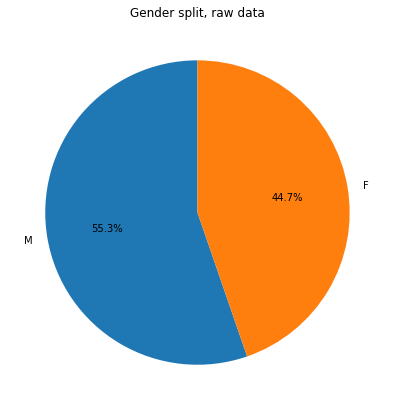

In [216]:
fig = plt.figure(figsize=(7,7))
fig.patch.set_facecolor('white')
data.gender.value_counts().plot.pie(startangle = 90, autopct='%1.1f%%')
plt.title('Gender split, raw data')
plt.ylabel('')
plt.show()

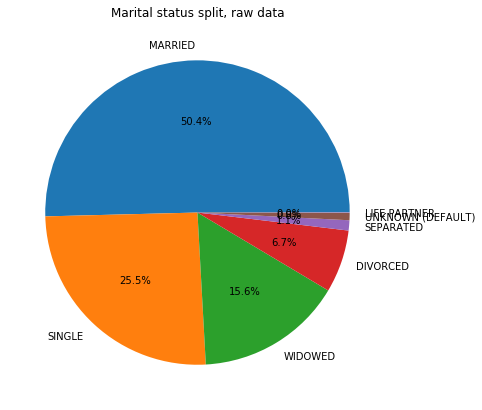

In [217]:
fig = plt.figure(figsize=(7,7))
fig.patch.set_facecolor('white')
data.marital_status.value_counts().plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Marital status split, raw data')
plt.ylabel('')
plt.show()

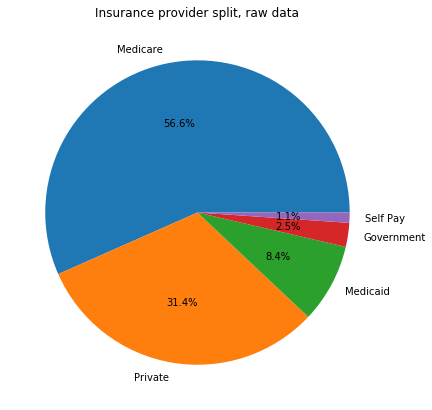

In [218]:
fig = plt.figure(figsize=(7,7))
fig.patch.set_facecolor('white')
data.insurance.value_counts().plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Insurance provider split, raw data')
plt.ylabel('')
plt.show()

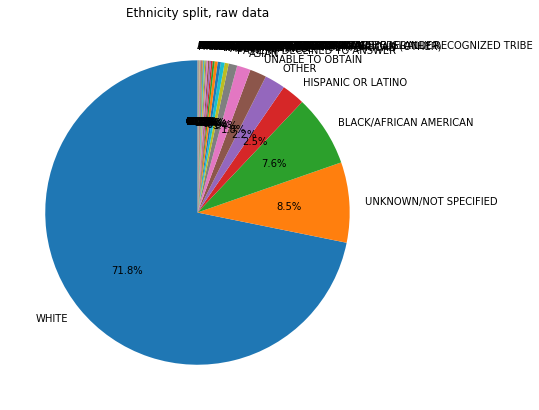

In [219]:
fig = plt.figure(figsize=(7,7))
fig.patch.set_facecolor('white')
data.ethnicity.value_counts().plot.pie(startangle = 90, autopct='%1.1f%%')
plt.title('Ethnicity split, raw data')
plt.ylabel('')
plt.show()

In [220]:
data.ethnicity.value_counts()

WHITE                                                       32063
UNKNOWN/NOT SPECIFIED                                        3804
BLACK/AFRICAN AMERICAN                                       3391
HISPANIC OR LATINO                                           1099
OTHER                                                         976
UNABLE TO OBTAIN                                              787
ASIAN                                                         645
PATIENT DECLINED TO ANSWER                                    407
ASIAN - CHINESE                                               194
HISPANIC/LATINO - PUERTO RICAN                                179
WHITE - RUSSIAN                                               150
BLACK/CAPE VERDEAN                                            143
MULTI RACE ETHNICITY                                           94
BLACK/HAITIAN                                                  74
ASIAN - ASIAN INDIAN                                           73
HISPANIC/L

In [238]:
data.replace(regex={'PATIENT DECLINED TO ANSWER':'UNKNOWN/NOT SPECIFIED', 'OTHER':'UNKNOWN/NOT SPECIFIED',
                    'UNABLE TO OBTAIN':'UNKNOWN/NOT SPECIFIED', r'.*BLACK.*':'BLACK',
                    r'.*WHITE.*':'WHITE', r'.*ASIAN.*':'ASIAN', r'.*HISPANIC.*':'HISPANIC',
                    r'.*PORTUGUESE.*':'WHITE', '.*AMERICAN INDIAN.*':'AMERICAN INDIAN',
                    'SOUTH AMERICAN':'HISPANIC', '.*NATIVE.*':'PACIFIC ISLANDER'}, inplace = True)
data.ethnicity.value_counts()

WHITE                    32414
UNKNOWN/NOT SPECIFIED     5974
BLACK                     3634
HISPANIC                  1436
ASIAN                     1011
MULTI RACE ETHNICITY        94
MIDDLE EASTERN              35
AMERICAN INDIAN             25
PACIFIC ISLANDER            14
CARIBBEAN ISLAND             7
Name: ethnicity, dtype: int64

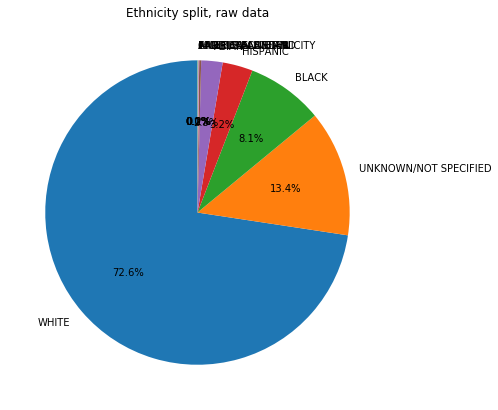

In [178]:
fig = plt.figure(figsize=(7,7))
fig.patch.set_facecolor('white')
data.ethnicity.value_counts().plot.pie(startangle = 90, autopct='%1.1f%%')
plt.title('Ethnicity split, raw data')
plt.ylabel('')
plt.show()

In [222]:
np.sum(data.isnull())

subject_id                  0
hadm_id                     0
admittime                   0
dischtime                   0
first_careunit              0
last_careunit               0
age                         0
icu_length_of_stay          2
hospital_expire_flag        0
mort_24                     0
mort_48                     0
mort_1yr                    0
gender                      0
ethnicity                   0
marital_status           2268
insurance                   0
urea_n_min                 33
urea_n_max                 33
urea_n_mean                33
platelets_min              43
platelets_max              43
platelets_mean             43
magnesium_max             448
albumin_min             15444
calcium_min              1726
resprate_min               15
resprate_max               15
resprate_mean              15
glucose_min               358
glucose_max               358
glucose_mean              358
hr_min                      2
hr_max                      2
hr_mean   

In [239]:
# Save clean dataset to csv
new_dir = 'data'
if not os.path.exists(new_dir):
        os.mkdir(new_dir)
data.to_csv('data/clean_data.csv', index=False)

# Data Cleaning and Further Exploratory Data Analysis

In [3]:
clean_data = pd.read_csv('data/clean_data.csv')

## How does ICU Length of Stay Vary With Some Parameters

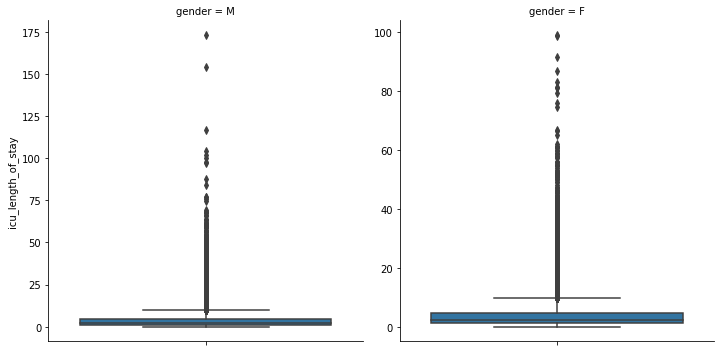

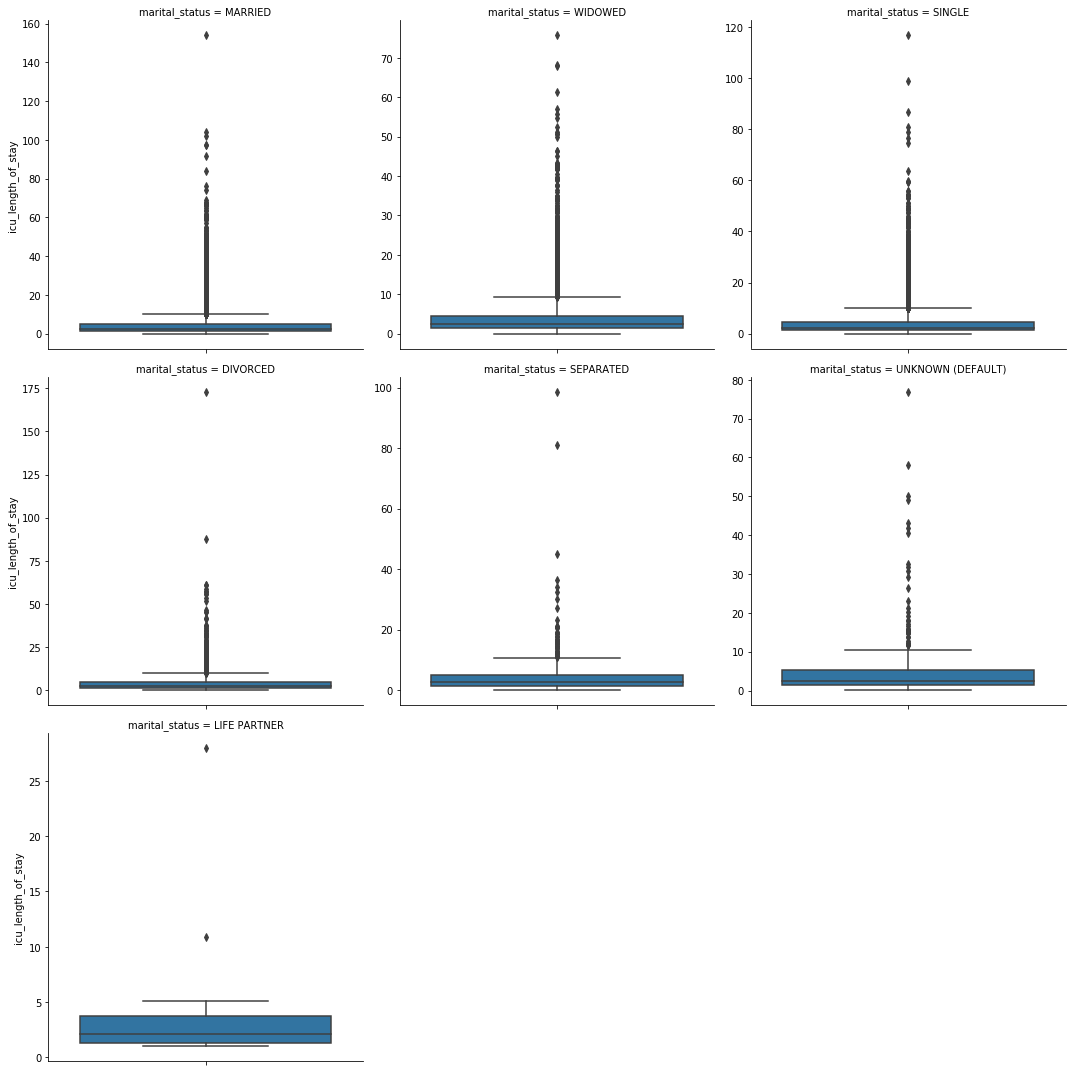

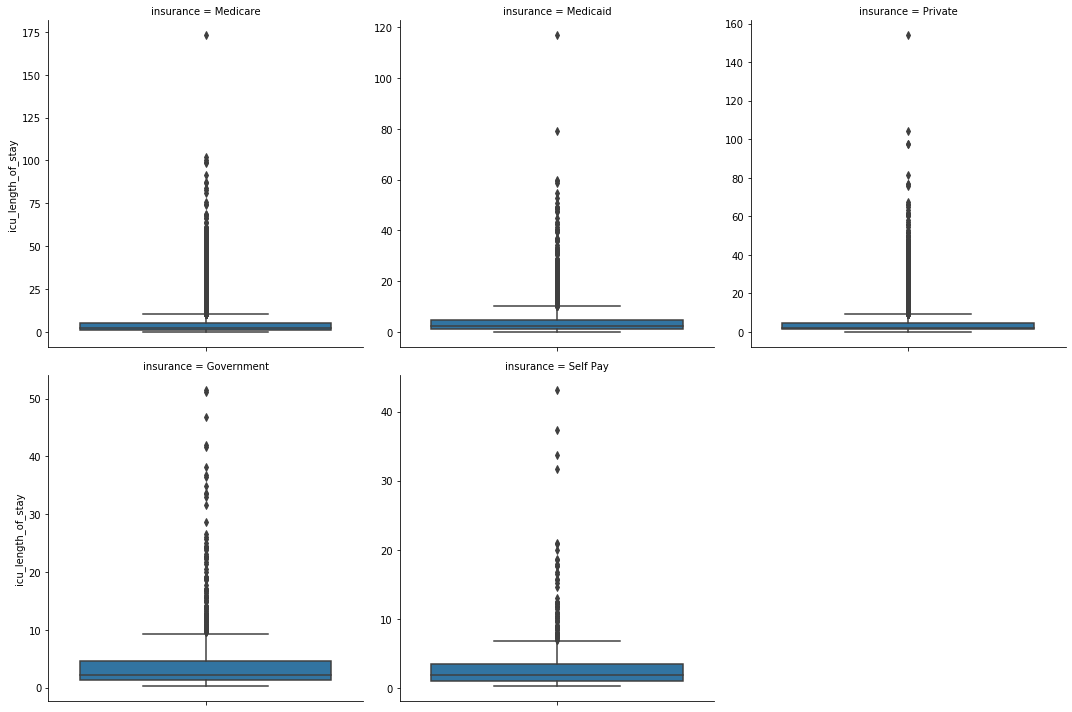

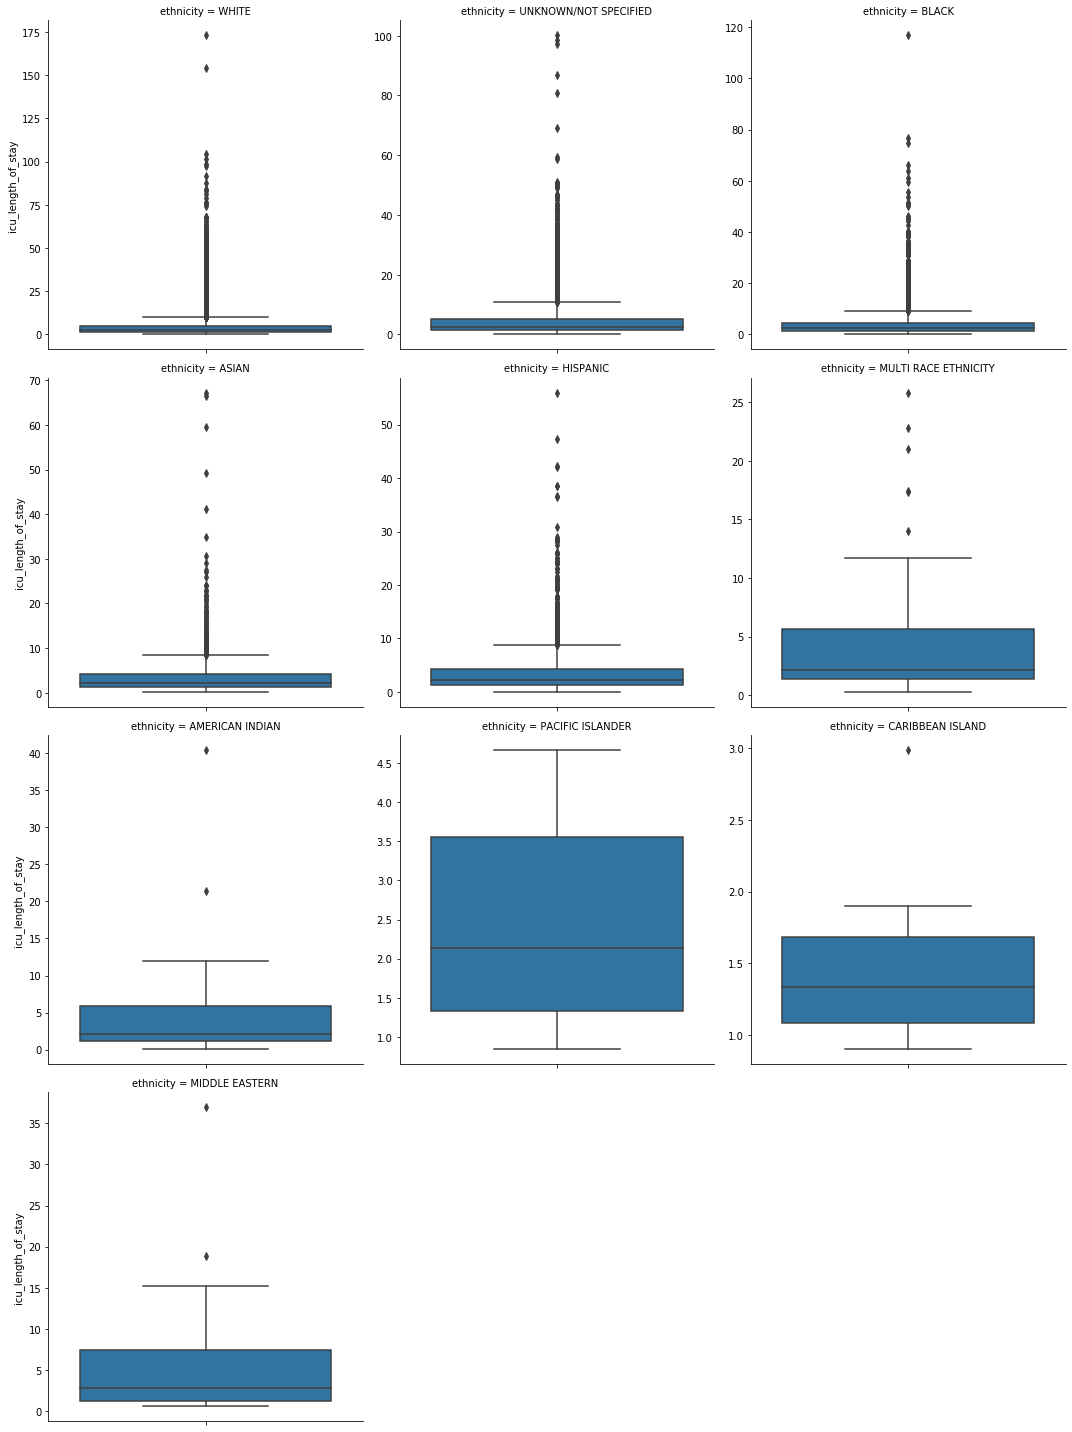

In [190]:
g = sns.catplot(y = 'icu_length_of_stay', col = 'gender', data=clean_data, kind='box',
                height=5, aspect=1, orient='v', col_wrap = 3, sharex=False, sharey=False)
plt.show()
g = sns.catplot(y = 'icu_length_of_stay', col = 'marital_status', data=clean_data, kind='box',
                height=5, aspect=1, orient='v', col_wrap = 3, sharex=False, sharey=False)
plt.show()
g = sns.catplot(y = 'icu_length_of_stay', col = 'insurance', data=clean_data, kind='box',
                height=5, aspect=1, orient='v', col_wrap = 3, sharex=False, sharey=False)
plt.show()
g = sns.catplot(y = 'icu_length_of_stay', col = 'ethnicity', data=clean_data, kind='box',
                height=5, aspect=1, orient='v', col_wrap = 3, sharex=False, sharey=False)
plt.show()

## How do Various Categories Compare in Mortalities

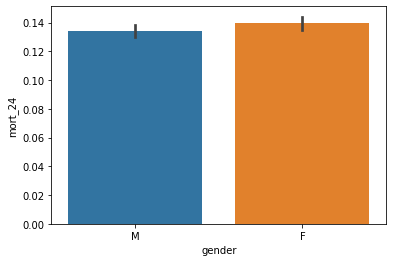

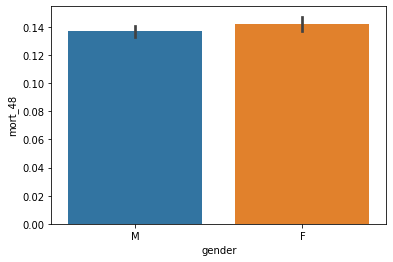

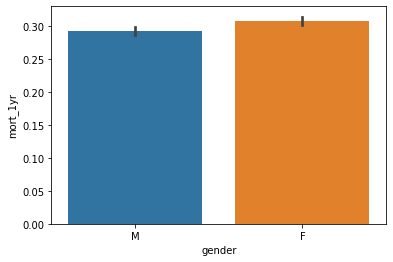

In [234]:
ax = sns.barplot(x='gender', y='mort_24', data=clean_data)
plt.show()
ax = sns.barplot(x='gender', y='mort_48', data=clean_data)
plt.show()
ax = sns.barplot(x='gender', y='mort_1yr', data=clean_data)
plt.show()

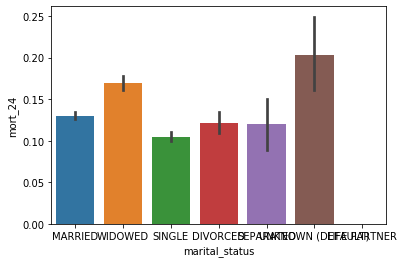

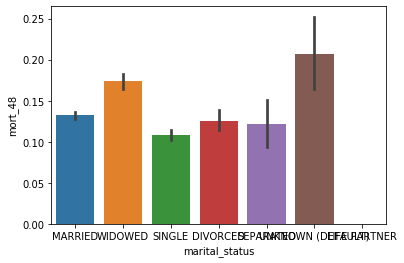

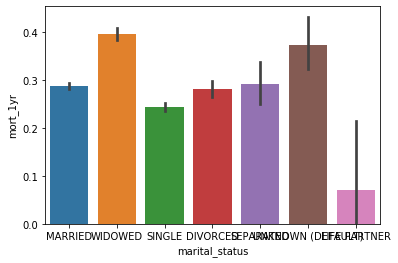

In [226]:
ax = sns.barplot(x='marital_status', y='mort_24', data=clean_data)
plt.show()
ax = sns.barplot(x='marital_status', y='mort_48', data=clean_data)
plt.show()
ax = sns.barplot(x='marital_status', y='mort_1yr', data=clean_data)
plt.show()

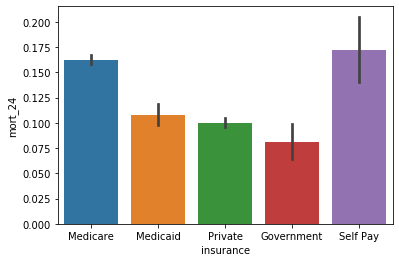

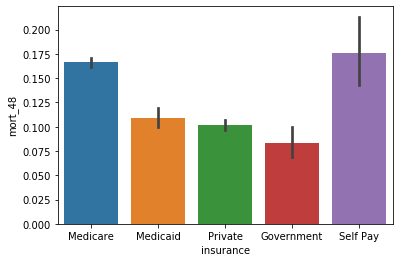

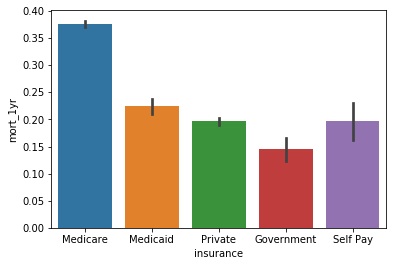

In [227]:
ax = sns.barplot(x='insurance', y='mort_24', data=clean_data)
plt.show()
ax = sns.barplot(x='insurance', y='mort_48', data=clean_data)
plt.show()
ax = sns.barplot(x='insurance', y='mort_1yr', data=clean_data)
plt.show()

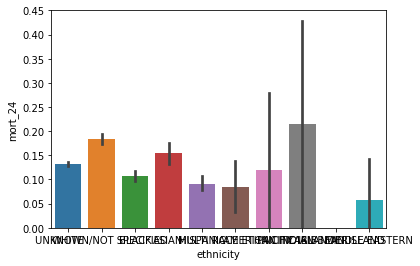

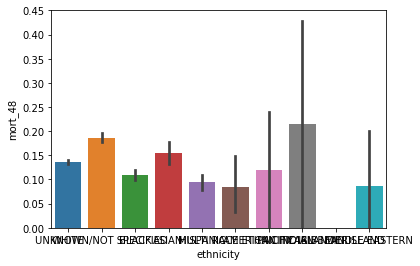

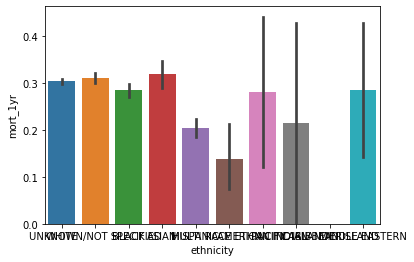

In [228]:
ax = sns.barplot(x='ethnicity', y='mort_24', data=clean_data)
plt.show()
ax = sns.barplot(x='ethnicity', y='mort_48', data=clean_data)
plt.show()
ax = sns.barplot(x='ethnicity', y='mort_1yr', data=clean_data)
plt.show()

## Let's Clean the Categorical Data

### First we Remove Data We no Longer Need

In [66]:
clean_df = clean_data.drop(['subject_id','hadm_id','admittime','dischtime','hospital_expire_flag'], axis = 1)
clean_df

,first_careunit,last_careunit,age,icu_length_of_stay,mort_24,mort_48,mort_1yr,gender,ethnicity,marital_status,...,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,temp_min,temp_max,temp_mean,urine_min,urine_mean,urine_max
0,MICU,MICU,76.526788,6.064560,0,0,1,M,WHITE,MARRIED,...,118.11,24.0,103.0,58.64,35.222223,37.666668,36.85,5.0,143.0,600.0
1,SICU,SICU,65.940670,3.672917,0,0,0,F,WHITE,MARRIED,...,153.75,40.0,88.0,60.01,35.611110,37.444445,36.56,20.0,81.0,200.0
2,MICU,MICU,41.790226,5.323056,1,1,1,M,UNKNOWN/NOT SPECIFIED,NaN,...,149.72,47.0,194.0,76.73,34.888891,37.888887,36.47,10.0,148.0,1100.0
3,SICU,SICU,72.372364,7.634815,1,1,1,M,WHITE,MARRIED,...,152.03,45.0,111.0,72.41,35.500001,38.500002,37.24,30.0,172.0,540.0
4,CCU,CSRU,39.866116,3.666042,0,0,0,F,WHITE,NaN,...,132.27,39.0,90.0,65.22,35.944443,38.599998,37.48,30.0,98.0,260.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44639,MICU,MICU,53.808478,11.299838,0,0,0,M,WHITE,MARRIED,...,121.07,43.0,111.0,60.19,35.944444,39.166667,37.64,25.0,179.0,650.0
44640,TSICU,TSICU,47.717278,3.142616,0,0,0,M,WHITE,MARRIED,...,161.63,65.0,172.0,83.27,36.055556,37.611111,36.89,20.0,144.0,1000.0
44641,MICU,MICU,65.772151,1.974456,0,0,0,F,WHITE,WIDOWED,...,139.52,38.0,69.0,54.61,36.111111,36.888889,36.51,25.0,134.0,600.0
44642,CSRU,CSRU,88.698269,2.161481,0,0,1,F,WHITE,MARRIED,...,131.48,39.0,95.0,51.26,36.444444,37.611111,36.96,0.0,67.0,250.0


### Let's Seperate Data Into Categorical, Numeric, and Labels for Better Visualization/Processing

In [67]:
categ_data = clean_df.copy()[['first_careunit','last_careunit', 'gender', 'ethnicity', 'marital_status', 'insurance']]
categ_data

,first_careunit,last_careunit,gender,ethnicity,marital_status,insurance
0,MICU,MICU,M,WHITE,MARRIED,Medicare
1,SICU,SICU,F,WHITE,MARRIED,Medicare
2,MICU,MICU,M,UNKNOWN/NOT SPECIFIED,NaN,Medicaid
3,SICU,SICU,M,WHITE,MARRIED,Medicare
4,CCU,CSRU,F,WHITE,NaN,Medicaid
...,...,...,...,...,...,...
44639,MICU,MICU,M,WHITE,MARRIED,Private
44640,TSICU,TSICU,M,WHITE,MARRIED,Private
44641,MICU,MICU,F,WHITE,WIDOWED,Medicare
44642,CSRU,CSRU,F,WHITE,MARRIED,Medicare


In [68]:
numeric_data = clean_df.copy().loc[:,~clean_df.columns.isin(['first_careunit','last_careunit', 
                                                             'gender', 'ethnicity', 'marital_status', 
                                                             'insurance','mort_24','mort_48','mort_1yr'])]
numeric_data

,age,icu_length_of_stay,urea_n_min,urea_n_max,urea_n_mean,platelets_min,platelets_max,platelets_mean,magnesium_max,albumin_min,...,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,temp_min,temp_max,temp_mean,urine_min,urine_mean,urine_max
0,76.526788,6.064560,15.0,53.0,28.133333,121.0,359.0,210.866667,3.5,1.8,...,118.11,24.0,103.0,58.64,35.222223,37.666668,36.85,5.0,143.0,600.0
1,65.940670,3.672917,16.0,91.0,53.941176,152.0,331.0,247.947368,3.3,2.7,...,153.75,40.0,88.0,60.01,35.611110,37.444445,36.56,20.0,81.0,200.0
2,41.790226,5.323056,16.0,33.0,22.714286,221.0,330.0,274.250000,3.0,2.9,...,149.72,47.0,194.0,76.73,34.888891,37.888887,36.47,10.0,148.0,1100.0
3,72.372364,7.634815,28.0,41.0,32.214286,51.0,706.0,250.235294,2.9,2.2,...,152.03,45.0,111.0,72.41,35.500001,38.500002,37.24,30.0,172.0,540.0
4,39.866116,3.666042,13.0,22.0,16.200000,74.0,273.0,161.800000,2.4,3.9,...,132.27,39.0,90.0,65.22,35.944443,38.599998,37.48,30.0,98.0,260.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44639,53.808478,11.299838,11.0,23.0,17.333333,247.0,948.0,558.166667,2.6,2.4,...,121.07,43.0,111.0,60.19,35.944444,39.166667,37.64,25.0,179.0,650.0
44640,47.717278,3.142616,13.0,31.0,20.333333,151.0,425.0,254.500000,2.5,NaN,...,161.63,65.0,172.0,83.27,36.055556,37.611111,36.89,20.0,144.0,1000.0
44641,65.772151,1.974456,34.0,56.0,47.500000,100.0,188.0,126.800000,2.1,2.0,...,139.52,38.0,69.0,54.61,36.111111,36.888889,36.51,25.0,134.0,600.0
44642,88.698269,2.161481,10.0,13.0,11.500000,124.0,189.0,159.666667,2.5,NaN,...,131.48,39.0,95.0,51.26,36.444444,37.611111,36.96,0.0,67.0,250.0


In [69]:
labels_data = clean_df.copy()[['mort_24','mort_48','mort_1yr']]
labels_data

,mort_24,mort_48,mort_1yr
0,0,0,1
1,0,0,0
2,1,1,1
3,1,1,1
4,0,0,0
...,...,...,...
44639,0,0,0
44640,0,0,0
44641,0,0,0
44642,0,0,1


### First We Process The Categorical Data

In [70]:
categ_data['first_careunit'].value_counts()

MICU     16167
CSRU      8857
SICU      7798
CCU       5912
TSICU     5910
Name: first_careunit, dtype: int64

In [71]:
categ_data['last_careunit'].value_counts()

MICU     16378
CSRU      8949
SICU      8117
TSICU     5627
CCU       5573
Name: last_careunit, dtype: int64

In [72]:
careunit_map = {'MICU':1,'CSRU':2, 'SICU':3, 'CCU':4,'TSICU':5}
categ_data.replace(to_replace=careunit_map, inplace=True)
categ_data

,first_careunit,last_careunit,gender,ethnicity,marital_status,insurance
0,1,1,M,WHITE,MARRIED,Medicare
1,3,3,F,WHITE,MARRIED,Medicare
2,1,1,M,UNKNOWN/NOT SPECIFIED,NaN,Medicaid
3,3,3,M,WHITE,MARRIED,Medicare
4,4,2,F,WHITE,NaN,Medicaid
...,...,...,...,...,...,...
44639,1,1,M,WHITE,MARRIED,Private
44640,5,5,M,WHITE,MARRIED,Private
44641,1,1,F,WHITE,WIDOWED,Medicare
44642,2,2,F,WHITE,MARRIED,Medicare


In [73]:
gender_map = {'M':1,'F':2}
categ_data.replace(to_replace=gender_map, inplace=True)
categ_data

,first_careunit,last_careunit,gender,ethnicity,marital_status,insurance
0,1,1,1,WHITE,MARRIED,Medicare
1,3,3,2,WHITE,MARRIED,Medicare
2,1,1,1,UNKNOWN/NOT SPECIFIED,NaN,Medicaid
3,3,3,1,WHITE,MARRIED,Medicare
4,4,2,2,WHITE,NaN,Medicaid
...,...,...,...,...,...,...
44639,1,1,1,WHITE,MARRIED,Private
44640,5,5,1,WHITE,MARRIED,Private
44641,1,1,2,WHITE,WIDOWED,Medicare
44642,2,2,2,WHITE,MARRIED,Medicare


In [74]:
categ_data['ethnicity'].value_counts()

WHITE                    32414
UNKNOWN/NOT SPECIFIED     5974
BLACK                     3634
HISPANIC                  1436
ASIAN                     1011
MULTI RACE ETHNICITY        94
MIDDLE EASTERN              35
AMERICAN INDIAN             25
PACIFIC ISLANDER            14
CARIBBEAN ISLAND             7
Name: ethnicity, dtype: int64

In [75]:
ethnicity_map = {'WHITE':1,'UNKNOWN/NOT SPECIFIED':2,'BLACK':3,
                 'HISPANIC':4,'ASIAN':5,'MULTI RACE ETHNICITY':6,
                 'MIDDLE EASTERN':7,'AMERICAN INDIAN':8, 
                 'PACIFIC ISLANDER':9,'CARIBBEAN ISLAND':10}
categ_data.replace(to_replace=ethnicity_map, inplace=True)
categ_data

,first_careunit,last_careunit,gender,ethnicity,marital_status,insurance
0,1,1,1,1,MARRIED,Medicare
1,3,3,2,1,MARRIED,Medicare
2,1,1,1,2,NaN,Medicaid
3,3,3,1,1,MARRIED,Medicare
4,4,2,2,1,NaN,Medicaid
...,...,...,...,...,...,...
44639,1,1,1,1,MARRIED,Private
44640,5,5,1,1,MARRIED,Private
44641,1,1,2,1,WIDOWED,Medicare
44642,2,2,2,1,MARRIED,Medicare


In [76]:
categ_data['marital_status'].value_counts()

MARRIED              21359
SINGLE               10794
WIDOWED               6598
DIVORCED              2823
SEPARATED              459
UNKNOWN (DEFAULT)      329
LIFE PARTNER            14
Name: marital_status, dtype: int64

In [77]:
marital_map = {'MARRIED':1,'SINGLE':2,'WIDOWED':3,
               'DIVORCED':4, 'SEPARATED':5,'UNKNOWN (DEFAULT)':6,
               'LIFE PARTNER':7, np.nan:6}
categ_data.replace(to_replace=marital_map, inplace=True)
categ_data

,first_careunit,last_careunit,gender,ethnicity,marital_status,insurance
0,1,1,1,1,1,Medicare
1,3,3,2,1,1,Medicare
2,1,1,1,2,6,Medicaid
3,3,3,1,1,1,Medicare
4,4,2,2,1,6,Medicaid
...,...,...,...,...,...,...
44639,1,1,1,1,1,Private
44640,5,5,1,1,1,Private
44641,1,1,2,1,3,Medicare
44642,2,2,2,1,1,Medicare


In [78]:
categ_data['insurance'].value_counts()

Medicare      25281
Private       13996
Medicaid       3749
Government     1135
Self Pay        483
Name: insurance, dtype: int64

In [79]:
insurance_map = {'Medicare':1,'Private':2,'Medicaid':3,
                 'Government':4,'Self Pay':5}
categ_data.replace(to_replace=insurance_map, inplace=True)
categ_data

,first_careunit,last_careunit,gender,ethnicity,marital_status,insurance
0,1,1,1,1,1,1
1,3,3,2,1,1,1
2,1,1,1,2,6,3
3,3,3,1,1,1,1
4,4,2,2,1,6,3
...,...,...,...,...,...,...
44639,1,1,1,1,1,2
44640,5,5,1,1,1,2
44641,1,1,2,1,3,1
44642,2,2,2,1,1,1


In [80]:
categ_data.apply(pd.to_numeric, errors = 'ignore')
# Check Numeric
np.sum(categ_data['first_careunit'])
np.sum(categ_data['last_careunit'])
np.sum(categ_data['gender'])
np.sum(categ_data['ethnicity'])
np.sum(categ_data['marital_status'])
np.sum(categ_data['insurance'])
print('Checks Out!!!')

Checks Out!!!


In [81]:
# Check Null
np.sum(categ_data.isnull())

first_careunit    0
last_careunit     0
gender            0
ethnicity         0
marital_status    0
insurance         0
dtype: int64

### Now Let's Process The Numeric Data

In [82]:
numeric_data

,age,icu_length_of_stay,urea_n_min,urea_n_max,urea_n_mean,platelets_min,platelets_max,platelets_mean,magnesium_max,albumin_min,...,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,temp_min,temp_max,temp_mean,urine_min,urine_mean,urine_max
0,76.526788,6.064560,15.0,53.0,28.133333,121.0,359.0,210.866667,3.5,1.8,...,118.11,24.0,103.0,58.64,35.222223,37.666668,36.85,5.0,143.0,600.0
1,65.940670,3.672917,16.0,91.0,53.941176,152.0,331.0,247.947368,3.3,2.7,...,153.75,40.0,88.0,60.01,35.611110,37.444445,36.56,20.0,81.0,200.0
2,41.790226,5.323056,16.0,33.0,22.714286,221.0,330.0,274.250000,3.0,2.9,...,149.72,47.0,194.0,76.73,34.888891,37.888887,36.47,10.0,148.0,1100.0
3,72.372364,7.634815,28.0,41.0,32.214286,51.0,706.0,250.235294,2.9,2.2,...,152.03,45.0,111.0,72.41,35.500001,38.500002,37.24,30.0,172.0,540.0
4,39.866116,3.666042,13.0,22.0,16.200000,74.0,273.0,161.800000,2.4,3.9,...,132.27,39.0,90.0,65.22,35.944443,38.599998,37.48,30.0,98.0,260.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44639,53.808478,11.299838,11.0,23.0,17.333333,247.0,948.0,558.166667,2.6,2.4,...,121.07,43.0,111.0,60.19,35.944444,39.166667,37.64,25.0,179.0,650.0
44640,47.717278,3.142616,13.0,31.0,20.333333,151.0,425.0,254.500000,2.5,NaN,...,161.63,65.0,172.0,83.27,36.055556,37.611111,36.89,20.0,144.0,1000.0
44641,65.772151,1.974456,34.0,56.0,47.500000,100.0,188.0,126.800000,2.1,2.0,...,139.52,38.0,69.0,54.61,36.111111,36.888889,36.51,25.0,134.0,600.0
44642,88.698269,2.161481,10.0,13.0,11.500000,124.0,189.0,159.666667,2.5,NaN,...,131.48,39.0,95.0,51.26,36.444444,37.611111,36.96,0.0,67.0,250.0


In [83]:
stats = dict.fromkeys(numeric_data.columns, None)
for col in numeric_data.columns:
    stats[col] = numeric_data[col].describe()

In [84]:
numeric_data['outlier'] = 0
numeric_data

,age,icu_length_of_stay,urea_n_min,urea_n_max,urea_n_mean,platelets_min,platelets_max,platelets_mean,magnesium_max,albumin_min,...,diasbp_min,diasbp_max,diasbp_mean,temp_min,temp_max,temp_mean,urine_min,urine_mean,urine_max,outlier
0,76.526788,6.064560,15.0,53.0,28.133333,121.0,359.0,210.866667,3.5,1.8,...,24.0,103.0,58.64,35.222223,37.666668,36.85,5.0,143.0,600.0,0
1,65.940670,3.672917,16.0,91.0,53.941176,152.0,331.0,247.947368,3.3,2.7,...,40.0,88.0,60.01,35.611110,37.444445,36.56,20.0,81.0,200.0,0
2,41.790226,5.323056,16.0,33.0,22.714286,221.0,330.0,274.250000,3.0,2.9,...,47.0,194.0,76.73,34.888891,37.888887,36.47,10.0,148.0,1100.0,0
3,72.372364,7.634815,28.0,41.0,32.214286,51.0,706.0,250.235294,2.9,2.2,...,45.0,111.0,72.41,35.500001,38.500002,37.24,30.0,172.0,540.0,0
4,39.866116,3.666042,13.0,22.0,16.200000,74.0,273.0,161.800000,2.4,3.9,...,39.0,90.0,65.22,35.944443,38.599998,37.48,30.0,98.0,260.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44639,53.808478,11.299838,11.0,23.0,17.333333,247.0,948.0,558.166667,2.6,2.4,...,43.0,111.0,60.19,35.944444,39.166667,37.64,25.0,179.0,650.0,0
44640,47.717278,3.142616,13.0,31.0,20.333333,151.0,425.0,254.500000,2.5,NaN,...,65.0,172.0,83.27,36.055556,37.611111,36.89,20.0,144.0,1000.0,0
44641,65.772151,1.974456,34.0,56.0,47.500000,100.0,188.0,126.800000,2.1,2.0,...,38.0,69.0,54.61,36.111111,36.888889,36.51,25.0,134.0,600.0,0
44642,88.698269,2.161481,10.0,13.0,11.500000,124.0,189.0,159.666667,2.5,NaN,...,39.0,95.0,51.26,36.444444,37.611111,36.96,0.0,67.0,250.0,0


#### Reject Extreme Outliers and Replace NaN with Random Normal About Mean with STD = sqrt(std)

In [85]:
count = 0
for i in range(len(numeric_data)):
    for col in numeric_data.columns[:-1]:
        value = numeric_data.loc[i,col]
        Q1 = stats[col]['25%']
        Q3 = stats[col]['75%']
        IQR = Q3-Q1
        step = 3*(IQR)
        cond1 = Q1 - step
        cond2 = Q3 + step
        if (value < cond1 or value > cond2) and numeric_data.loc[i,'outlier'] == 0:
            numeric_data.loc[i,'outlier'] = 1
        if np.isnan(value):
            # Replace NaN with statistically insignificant value
            numeric_data.loc[i,col] = np.random.normal(stats[col]['mean'], np.sqrt(stats[col]['std']))

In [86]:
np.sum(numeric_data.isnull())

age                   0
icu_length_of_stay    0
urea_n_min            0
urea_n_max            0
urea_n_mean           0
platelets_min         0
platelets_max         0
platelets_mean        0
magnesium_max         0
albumin_min           0
calcium_min           0
resprate_min          0
resprate_max          0
resprate_mean         0
glucose_min           0
glucose_max           0
glucose_mean          0
hr_min                0
hr_max                0
hr_mean               0
sysbp_min             0
sysbp_max             0
sysbp_mean            0
diasbp_min            0
diasbp_max            0
diasbp_mean           0
temp_min              0
temp_max              0
temp_mean             0
urine_min             0
urine_mean            0
urine_max             0
outlier               0
dtype: int64

In [112]:
rejected = np.sum(numeric_data['outlier'])
remain = len(numeric_data['outlier']) - np.sum(numeric_data['outlier'])
print(f'\nRejected: {rejected}\n')
print(f'Data Remaining: {remain}\n')


Rejected: 10807

Data Remaining: 33837



In [113]:
numeric_data

,age,icu_length_of_stay,urea_n_min,urea_n_max,urea_n_mean,platelets_min,platelets_max,platelets_mean,magnesium_max,albumin_min,...,diasbp_min,diasbp_max,diasbp_mean,temp_min,temp_max,temp_mean,urine_min,urine_mean,urine_max,outlier
0,76.526788,6.064560,15.0,53.0,28.133333,121.0,359.0,210.866667,3.5,1.800000,...,24.0,103.0,58.64,35.222223,37.666668,36.85,5.0,143.0,600.0,0
1,65.940670,3.672917,16.0,91.0,53.941176,152.0,331.0,247.947368,3.3,2.700000,...,40.0,88.0,60.01,35.611110,37.444445,36.56,20.0,81.0,200.0,0
2,41.790226,5.323056,16.0,33.0,22.714286,221.0,330.0,274.250000,3.0,2.900000,...,47.0,194.0,76.73,34.888891,37.888887,36.47,10.0,148.0,1100.0,1
3,72.372364,7.634815,28.0,41.0,32.214286,51.0,706.0,250.235294,2.9,2.200000,...,45.0,111.0,72.41,35.500001,38.500002,37.24,30.0,172.0,540.0,0
4,39.866116,3.666042,13.0,22.0,16.200000,74.0,273.0,161.800000,2.4,3.900000,...,39.0,90.0,65.22,35.944443,38.599998,37.48,30.0,98.0,260.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44639,53.808478,11.299838,11.0,23.0,17.333333,247.0,948.0,558.166667,2.6,2.400000,...,43.0,111.0,60.19,35.944444,39.166667,37.64,25.0,179.0,650.0,0
44640,47.717278,3.142616,13.0,31.0,20.333333,151.0,425.0,254.500000,2.5,2.459032,...,65.0,172.0,83.27,36.055556,37.611111,36.89,20.0,144.0,1000.0,0
44641,65.772151,1.974456,34.0,56.0,47.500000,100.0,188.0,126.800000,2.1,2.000000,...,38.0,69.0,54.61,36.111111,36.888889,36.51,25.0,134.0,600.0,0
44642,88.698269,2.161481,10.0,13.0,11.500000,124.0,189.0,159.666667,2.5,1.402011,...,39.0,95.0,51.26,36.444444,37.611111,36.96,0.0,67.0,250.0,0


#### Let's Merge the Feature Set to Remove Outliers

In [115]:
merged_data = categ_data.join([numeric_data, labels_data])
merged_data

,first_careunit,last_careunit,gender,ethnicity,marital_status,insurance,age,icu_length_of_stay,urea_n_min,urea_n_max,...,temp_min,temp_max,temp_mean,urine_min,urine_mean,urine_max,outlier,mort_24,mort_48,mort_1yr
0,1,1,1,1,1,1,76.526788,6.064560,15.0,53.0,...,35.222223,37.666668,36.85,5.0,143.0,600.0,0,0,0,1
1,3,3,2,1,1,1,65.940670,3.672917,16.0,91.0,...,35.611110,37.444445,36.56,20.0,81.0,200.0,0,0,0,0
2,1,1,1,2,6,3,41.790226,5.323056,16.0,33.0,...,34.888891,37.888887,36.47,10.0,148.0,1100.0,1,1,1,1
3,3,3,1,1,1,1,72.372364,7.634815,28.0,41.0,...,35.500001,38.500002,37.24,30.0,172.0,540.0,0,1,1,1
4,4,2,2,1,6,3,39.866116,3.666042,13.0,22.0,...,35.944443,38.599998,37.48,30.0,98.0,260.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44639,1,1,1,1,1,2,53.808478,11.299838,11.0,23.0,...,35.944444,39.166667,37.64,25.0,179.0,650.0,0,0,0,0
44640,5,5,1,1,1,2,47.717278,3.142616,13.0,31.0,...,36.055556,37.611111,36.89,20.0,144.0,1000.0,0,0,0,0
44641,1,1,2,1,3,1,65.772151,1.974456,34.0,56.0,...,36.111111,36.888889,36.51,25.0,134.0,600.0,0,0,0,0
44642,2,2,2,1,1,1,88.698269,2.161481,10.0,13.0,...,36.444444,37.611111,36.96,0.0,67.0,250.0,0,0,0,1


In [121]:
# Remove Outliers
merged_data = merged_data[merged_data['outlier']==0].reset_index(drop=True).drop(columns='outlier')
merged_data

,first_careunit,last_careunit,gender,ethnicity,marital_status,insurance,age,icu_length_of_stay,urea_n_min,urea_n_max,...,diasbp_mean,temp_min,temp_max,temp_mean,urine_min,urine_mean,urine_max,mort_24,mort_48,mort_1yr
0,1,1,1,1,1,1,76.526788,6.064560,15.0,53.0,...,58.64,35.222223,37.666668,36.85,5.0,143.0,600.0,0,0,1
1,3,3,2,1,1,1,65.940670,3.672917,16.0,91.0,...,60.01,35.611110,37.444445,36.56,20.0,81.0,200.0,0,0,0
2,3,3,1,1,1,1,72.372364,7.634815,28.0,41.0,...,72.41,35.500001,38.500002,37.24,30.0,172.0,540.0,1,1,1
3,4,2,2,1,6,3,39.866116,3.666042,13.0,22.0,...,65.22,35.944443,38.599998,37.48,30.0,98.0,260.0,0,0,0
4,2,2,2,1,1,2,47.454296,2.071007,10.0,12.0,...,52.36,36.000002,38.000001,36.75,5.0,42.0,150.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33832,1,1,1,1,1,2,53.808478,11.299838,11.0,23.0,...,60.19,35.944444,39.166667,37.64,25.0,179.0,650.0,0,0,0
33833,5,5,1,1,1,2,47.717278,3.142616,13.0,31.0,...,83.27,36.055556,37.611111,36.89,20.0,144.0,1000.0,0,0,0
33834,1,1,2,1,3,1,65.772151,1.974456,34.0,56.0,...,54.61,36.111111,36.888889,36.51,25.0,134.0,600.0,0,0,0
33835,2,2,2,1,1,1,88.698269,2.161481,10.0,13.0,...,51.26,36.444444,37.611111,36.96,0.0,67.0,250.0,0,0,1


### Save Table Again:

In [122]:
# Save clean dataset to csv
new_dir = 'data'
if not os.path.exists(new_dir):
        os.mkdir(new_dir)
merged_data.to_csv('data/final_data.csv', index=False)

# Modeling

* My inspiration for this model was to have a simple fully connected layer based model. The model has a categorical branch and a descriptive branch that merge and produce a classification result.

### Split Training Data into Val and Test:

In [193]:
final_data = pd.read_csv('data/final_data.csv')

In [176]:
train, test = train_test_split(final_data, test_size=0.2)
train, val = train_test_split(final_data, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

27069 train examples
6768 validation examples
6768 test examples


In [228]:
reject_col = ['first_careunit','last_careunit','gender','ethnicity','marital_status','insurance','mort_24','mort_48','mort_1yr']
label_col = ['mort_24','mort_48','mort_1yr']
x_train1 = train.copy().loc[:,~train.columns.isin(reject_col)]
x_train2 = train.copy().loc[:,train.columns.isin(reject_col[:-3])]
y_train = train.copy().loc[:,label_col]
print(x_train1.shape)
print(x_train2.shape)
print(y_train.shape)

(27069, 32)
(27069, 6)
(27069, 3)


In [229]:
x_val1 = val.copy().loc[:,~val.columns.isin(reject_col)]
x_val2 = val.copy().loc[:,val.columns.isin(reject_col[:-3])]
y_val = val.copy().loc[:,label_col]
print(x_val1.shape)
print(x_val2.shape)
print(y_val.shape)

(6768, 32)
(6768, 6)
(6768, 3)


In [231]:
x_test1 = test.copy().loc[:,~test.columns.isin(reject_col)]
x_test2 = test.copy().loc[:,test.columns.isin(reject_col[:-3])]
y_test = test.copy().loc[:,label_col]
print(x_test1.shape)
print(x_test2.shape)
print(y_test.shape)

(6768, 32)
(6768, 6)
(6768, 3)


In [232]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train1 = sc.fit_transform(x_train1)
x_train2 = sc.fit_transform(x_train2)
x_val1 = sc.fit_transform(x_val1)
x_val2 = sc.fit_transform(x_val2)
x_test1 = sc.fit_transform(x_test1)
x_test2 = sc.fit_transform(x_test2)

In [266]:
input_layer_1 = Input(shape=(x_train1.shape[1],))
dense_layer_1a = Dense(10, activation='relu')(input_layer_1)
dense_layer_2a = Dropout(0.1)(dense_layer_1a)
dense_layer_3a = Dense(10, activation='relu')(dense_layer_2a)
dense_layer_4a = Dropout(0.1)(dense_layer_3a)

input_layer_2 = Input(shape=(x_train2.shape[1],))
dense_layer_1b = Dense(10, activation='relu')(input_layer_2)
dense_layer_2b = Dropout(0.1)(dense_layer_1b)
dense_layer_3b = Dense(10, activation='relu')(dense_layer_2b)
dense_layer_4b = Dropout(0.1)(dense_layer_3b)

merge = Concatenate(axis=1)([dense_layer_4a, dense_layer_4b])
dense_layer_5 = Dense(10, activation='relu')(merge)
dense_layer_6 = Dropout(0.1)(dense_layer_5)
dense_layer_7 = Dense(5, activation='relu')(dense_layer_6)
dense_layer_8 = Dropout(0.1)(dense_layer_7)

output = Dense(y_train.shape[1], activation='softmax')(dense_layer_8)

model = Model(inputs=[input_layer_1,input_layer_2], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'binary_crossentropy', tf.keras.metrics.AUC()])

In [267]:
print(model.summary())

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_136 (Dense)               (None, 10)           330         input_43[0][0]                   
__________________________________________________________________________________________________
dense_138 (Dense)               (None, 10)           70          input_44[0][0]                   
___________________________________________________________________________________________

In [268]:
history = model.fit((x_train1, x_train2), y_train, batch_size=32, epochs=20, verbose=1, validation_data = ((x_val1, x_val2),y_val), shuffle=True)

Train on 27069 samples, validate on 6768 samples
Epoch 1/20
27069/27069 [==============================] - 6s 210us/sample - loss: 0.5046 - acc: 0.8345 - binary_crossentropy: 0.5046 - auc: 0.6117 - val_loss: 0.4921 - val_acc: 0.8522 - val_binary_crossentropy: 0.4921 - val_auc: 0.6354
Epoch 2/20
27069/27069 [==============================] - 4s 153us/sample - loss: 0.4996 - acc: 0.8341 - binary_crossentropy: 0.4996 - auc: 0.6271 - val_loss: 0.4907 - val_acc: 0.8423 - val_binary_crossentropy: 0.4907 - val_auc: 0.6533
Epoch 3/20
27069/27069 [==============================] - 4s 153us/sample - loss: 0.4986 - acc: 0.8276 - binary_crossentropy: 0.4986 - auc: 0.6457 - val_loss: 0.4896 - val_acc: 0.8347 - val_binary_crossentropy: 0.4896 - val_auc: 0.6790
Epoch 4/20
27069/27069 [==============================] - 4s 152us/sample - loss: 0.4975 - acc: 0.8253 - binary_crossentropy: 0.4975 - auc: 0.6525 - val_loss: 0.4893 - val_acc: 0.8430 - val_binary_crossentropy: 0.4893 - val_auc: 0.6753
Epoch 5

In [269]:
score = model.evaluate((x_test1, x_test2), y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

6768/6768 [==============================] - 1s 79us/sample - loss: 0.4927 - acc: 0.8300 - binary_crossentropy: 0.4927 - auc: 0.6797
Test Score: 0.49273971758835705
Test Accuracy: 0.83003354


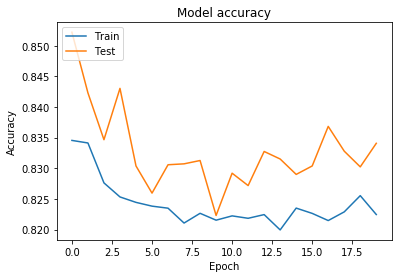

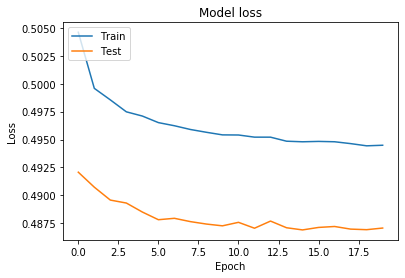

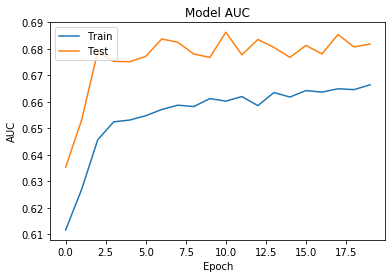

In [273]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot train/val AUC
# Plot training & validation loss values
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

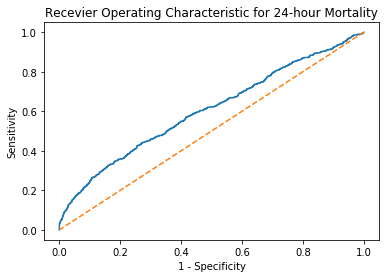

In [263]:
spec, sens, thresholds = sklearn.metrics.roc_curve(np.array(y_test)[:,0], model.predict((x_test1, x_test2))[:,0])
plt.plot(spec, sens)
plt.plot([1, 0],[1, 0], linestyle = "--")
plt.title('Recevier Operating Characteristic for 24-hour Mortality')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

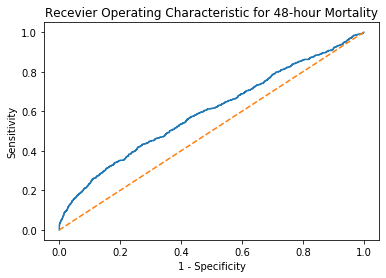

In [264]:
spec, sens, thresholds = sklearn.metrics.roc_curve(np.array(y_test)[:,1], model.predict((x_test1, x_test2))[:,1])
plt.plot(spec, sens)
plt.plot([1, 0],[1, 0], linestyle = "--")
plt.title('Recevier Operating Characteristic for 48-hour Mortality')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

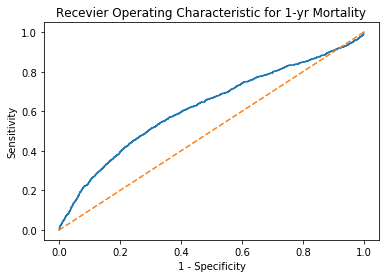

In [265]:
spec, sens, thresholds = sklearn.metrics.roc_curve(np.array(y_test)[:,2], model.predict((x_test1, x_test2))[:,2])
plt.plot(spec, sens)
plt.plot([1, 0],[1, 0], linestyle = "--")
plt.title('Recevier Operating Characteristic for 1-yr Mortality')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

# Suggestions / Conclusion

* For this model, I tried to keep the parameters at a minimum, and use quite simple features (mainly vitals), and thus avoiding something closer to a time series RNN type of model. I think the model could be improved by including time series, but that went against the spirit of having a simpler, more robust model. All in all, the accuracy of the model is quite good, over 80%, but the AUC could use some work. I think it might be interesting if the model included some derived severity scores in its calculation.

# References

* https://www.sciencedirect.com/science/article/pii/S1532046418300716#fn6
* https://github.com/YerevaNN/mimic3-benchmarks
* https://github.com/MIT-LCP/mimic-code
* Johnson, A., Pollard, T., & Mark, R. (2016). MIMIC-III Clinical Database (version 1.4). PhysioNet. https://doi.org/10.13026/C2XW26.
* Johnson, A. E. W., Pollard, T. J., Shen, L., Lehman, L. H., Feng, M., Ghassemi, M., Moody, B., Szolovits, P., Celi, L. A., & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. Scientific Data, 3, 160035.
* Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.
* https://github.com/YaronBlinder/MIMIC-III_readmission